In [1]:
import importlib
import sys

# Clearing all variables
%reset -f

# Re-importing everything
import pandas as pd
import numpy as np

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(f"TensorFlow version: {tf.__version__}")

# Seting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuring plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("libraries imported ")

TensorFlow version: 2.20.0
libraries imported 


In [4]:
print("LOADING DATASET")
# loading data 
df = pd.read_csv("US_Accidents_March23.csv")

print(f"\n Dataset Overview:")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

print(f"\n Target Distribution:")
print(df['Severity'].value_counts().sort_index())
print(f"\nPercentages:")
print(df['Severity'].value_counts(normalize=True).sort_index() * 100)

print(f"\n Class Imbalance Detected")
print("  handling  with class weights and balanced sampling")


LOADING DATASET

 Dataset Overview:
   Rows: 7,728,394
   Columns: 46
   Memory: 11.40 GB

 Target Distribution:
Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

Percentages:
Severity
1     0.871669
2    79.667017
3    16.812510
4     2.648804
Name: proportion, dtype: float64

 Class Imbalance Detected
  handling  with class weights and balanced sampling


In [5]:
print("FEATURE SELECTION")
selected_columns = [
    # Target
    'Severity',
    
    # Temporal
    'Start_Time',
    
    # Geographic (Randy's focus)
    'Start_Lat', 'Start_Lng',
    
    # Weather (High importance from Gavin's analysis)
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
    'Weather_Condition',
    
    # Infrastructure (Boolean features)
    'Junction', 'Traffic_Signal', 'Stop', 'Crossing',
    'Railway', 'Roundabout', 'Station', 'Bump',
    
    # Time of day
    'Sunrise_Sunset'
]

selected_columns = [col for col in selected_columns if col in df.columns]

df_selected = df[selected_columns].copy()

print(f" Selected {len(selected_columns)} features")
print(f"   Memory reduced to: {df_selected.memory_usage(deep=True).sum() / 1e6:.1f} MB")

del df
import gc
gc.collect()


FEATURE SELECTION
 Selected 20 features
   Memory reduced to: 2174.8 MB


0

In [6]:
print("SAMPLING STRATEGY")

SAMPLE_SIZE = 100000  

if len(df_selected) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE:,} rows from {len(df_selected):,}...")
    
    df_selected = df_selected.groupby('Severity', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), SAMPLE_SIZE // 4), random_state=42)
    )
    
    print(f" Sampled to {len(df_selected):,} rows")
    print("\nNew distribution:")
    print(df_selected['Severity'].value_counts().sort_index())


SAMPLING STRATEGY
Sampling 100,000 rows from 7,728,394...
 Sampled to 100,000 rows

New distribution:
Severity
1    25000
2    25000
3    25000
4    25000
Name: count, dtype: int64


In [7]:
print("DATA CLEANING")
# 1. Removing invalid coordinates/outside continental US
print("\n1. Geographic filtering")
before = len(df_selected)
df_selected = df_selected[
    (df_selected['Start_Lat'].between(24, 50)) &
    (df_selected['Start_Lng'].between(-125, -65))
]
print(f"   Removed {before - len(df_selected):,} rows with invalid coordinates")

# 2. Handling missing values
print("\n2. Handling missing values...")

# Weather: fill with median
weather_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)',
                'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
for col in weather_cols:
    if col in df_selected.columns:
        df_selected[col].fillna(df_selected[col].median(), inplace=True)

# Categorical: fill with Unknown
if 'Weather_Condition' in df_selected.columns:
    df_selected['Weather_Condition'].fillna('Clear', inplace=True)

if 'Sunrise_Sunset' in df_selected.columns:
    df_selected['Sunrise_Sunset'].fillna('Day', inplace=True)

# Boolean: fill with False
bool_cols = ['Junction', 'Traffic_Signal', 'Stop', 'Crossing',
             'Railway', 'Roundabout', 'Station', 'Bump']
for col in bool_cols:
    if col in df_selected.columns:
        df_selected[col].fillna(False, inplace=True)
        df_selected[col] = df_selected[col].astype('int8')

print(f"   Missing values: {df_selected.isnull().sum().sum()}")

# 3. Removing duplicates
before = len(df_selected)
df_selected = df_selected.drop_duplicates()
print(f"\n3. Removed {before - len(df_selected):,} duplicate rows")

print(f"\n Clean dataset: {df_selected.shape}")

DATA CLEANING

1. Geographic filtering
   Removed 0 rows with invalid coordinates

2. Handling missing values...
   Missing values: 0

3. Removed 539 duplicate rows

 Clean dataset: (99461, 20)


In [8]:
print("FEATURE ENGINEERING")

# 1. Temporal features
print("\n1. Creating temporal features...")
df_selected['Start_Time'] = pd.to_datetime(df_selected['Start_Time'], errors='coerce')
df_selected['Hour'] = df_selected['Start_Time'].dt.hour
df_selected['Day_of_Week'] = df_selected['Start_Time'].dt.dayofweek
df_selected['Month'] = df_selected['Start_Time'].dt.month
df_selected['Is_Weekend'] = (df_selected['Day_of_Week'] >= 5).astype('int8')
df_selected['Is_Rush_Hour'] = (
    ((df_selected['Hour'] >= 7) & (df_selected['Hour'] <= 9)) |
    ((df_selected['Hour'] >= 16) & (df_selected['Hour'] <= 19))
).astype('int8')
df_selected.drop('Start_Time', axis=1, inplace=True)
print("   ✓ Hour, Day_of_Week, Month, Is_Weekend, Is_Rush_Hour")

# 2. Weather risk score
print("\n2. Creating weather risk score...")
vis_max = df_selected['Visibility(mi)'].max()
precip_max = df_selected['Precipitation(in)'].max()
wind_max = df_selected['Wind_Speed(mph)'].max()

vis_norm = 1 - (df_selected['Visibility(mi)'] / (vis_max + 1e-6))
precip_norm = df_selected['Precipitation(in)'] / (precip_max + 1e-6)
wind_norm = df_selected['Wind_Speed(mph)'] / (wind_max + 1e-6)

df_selected['Weather_Risk_Score'] = (
    vis_norm * 0.4 + precip_norm * 0.3 + wind_norm * 0.3
).astype('float32')
print("   ✓ Weather_Risk_Score")

# 3. Infrastructure score
print("\n3. Creating infrastructure score...")
df_selected['Infrastructure_Score'] = df_selected[bool_cols].sum(axis=1).astype('int8')
print("   ✓ Infrastructure_Score")

# 4. Geohash encoding
print("\n4. Creating geographic features...")
try:
    import geohash2
    
    # Create geohash (precision 5 = ~4.9km cells)
    df_selected['GeoHash'] = df_selected.apply(
        lambda row: geohash2.encode(row['Start_Lat'], row['Start_Lng'], precision=5),
        axis=1
    )
    
    # Keeping only top 50 geohashes to avoid explosion
    top_geohashes = df_selected['GeoHash'].value_counts().head(50).index
    df_selected['GeoHash'] = df_selected['GeoHash'].apply(
        lambda x: x if x in top_geohashes else 'OTHER'
    )
    
    # Geohash statistics
    geohash_counts = df_selected['GeoHash'].value_counts()
    df_selected['Geohash_Density'] = df_selected['GeoHash'].map(geohash_counts).astype('int32')
    
    print("   ✓ GeoHash, Geohash_Density")
    
except ImportError:
    print("   geohash2 not installed, skipping geohash features")
    print("   Install with: pip install python-geohash")

# 5. Simplify weather condition 
print("\n5. Simplifying weather conditions...")
if 'Weather_Condition' in df_selected.columns:
    top_10_weather = df_selected['Weather_Condition'].value_counts().head(10).index
    df_selected['Weather_Condition'] = df_selected['Weather_Condition'].apply(
        lambda x: x if x in top_10_weather else 'Other'
    )
    print(f"   ✓ Reduced to {df_selected['Weather_Condition'].nunique()} categories")

print(f"\n Feature engineering complete!")
print(f"   Total features: {len(df_selected.columns) - 1}")


FEATURE ENGINEERING

1. Creating temporal features...
   ✓ Hour, Day_of_Week, Month, Is_Weekend, Is_Rush_Hour

2. Creating weather risk score...
   ✓ Weather_Risk_Score

3. Creating infrastructure score...
   ✓ Infrastructure_Score

4. Creating geographic features...
   geohash2 not installed, skipping geohash features
   Install with: pip install python-geohash

5. Simplifying weather conditions...
   ✓ Reduced to 11 categories

 Feature engineering complete!
   Total features: 25


In [9]:
print("ENCODING CATEGORICAL VARIABLES")
# Label encode categorical features 
categorical_features = ['Weather_Condition', 'Sunrise_Sunset']
if 'GeoHash' in df_selected.columns:
    categorical_features.append('GeoHash')

encoders = {}

for col in categorical_features:
    if col in df_selected.columns:
        le = LabelEncoder()
        df_selected[f'{col}_Encoded'] = le.fit_transform(df_selected[col]).astype('int16')
        encoders[col] = le
        df_selected.drop(col, axis=1, inplace=True)
        print(f"   ✓ {col}: {len(le.classes_)} categories → integers")

# Also drop lat/lon 
if 'Start_Lat' in df_selected.columns:
    df_selected.drop(['Start_Lat', 'Start_Lng'], axis=1, inplace=True)
    print("   ✓ Dropped Start_Lat, Start_Lng (spatial info in geohash)")

print(f"\n All features are now numeric!")


ENCODING CATEGORICAL VARIABLES
   ✓ Weather_Condition: 11 categories → integers
   ✓ Sunrise_Sunset: 2 categories → integers
   ✓ Dropped Start_Lat, Start_Lng (spatial info in geohash)

 All features are now numeric!


In [10]:
print("PREPARING FOR MODELING")

# Map severity to 3 classes (combining 3 and 4)
print("\n1. Mapping target variable...")
severity_map = {1: 0, 2: 1, 3: 2, 4: 2}  # Minor, Moderate, Severe
df_selected['Severity_Class'] = df_selected['Severity'].map(severity_map).astype('int8')
df_selected.drop('Severity', axis=1, inplace=True)

print("   Class distribution:")
for i, count in enumerate(df_selected['Severity_Class'].value_counts().sort_index()):
    pct = count / len(df_selected) * 100
    class_name = ['Minor', 'Moderate', 'Severe'][i]
    print(f"   {i} ({class_name}): {count:,} ({pct:.1f}%)")

# Separate features and target
print("\n2. Splitting features and target...")
X = df_selected.drop('Severity_Class', axis=1)
y = df_selected['Severity_Class']

print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")

# Train/test split 
print("\n3. Creating train/test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Test:  {X_test.shape[0]:,} samples")

# Scale features
print("\n4. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("   ✓ Features scaled (mean=0, std=1)")

del df_selected, X, y
gc.collect()

print(f"\n Data ready for training")


PREPARING FOR MODELING

1. Mapping target variable...
   Class distribution:
   0 (Minor): 24,576 (24.7%)
   1 (Moderate): 24,992 (25.1%)
   2 (Severe): 49,893 (50.2%)

2. Splitting features and target...
   Features shape: (99461, 23)
   Target shape: (99461,)

3. Creating train/test split...
   Train: 79,568 samples
   Test:  19,893 samples

4. Scaling features...
   ✓ Features scaled (mean=0, std=1)

 Data ready for training


In [11]:

print("BUILDING ATTENTION MECHANISM")


class FeatureAttentionLayer(layers.Layer):
    
    
    def __init__(self, attention_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.attention_dim = attention_dim
        
    def build(self, input_shape):
        # Attention scoring network
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(input_shape[-1], self.attention_dim),
            initializer='glorot_uniform',
            trainable=True
        )
        
        self.attention_bias = self.add_weight(
            name='attention_bias',
            shape=(self.attention_dim,),
            initializer='zeros',
            trainable=True
        )
        
        # Output projection
        self.output_weights = self.add_weight(
            name='output_weights',
            shape=(self.attention_dim, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        
        super().build(input_shape)
        
    def call(self, inputs):
        # Compute attention scores
        attention_hidden = tf.nn.relu(
            tf.matmul(inputs, self.attention_weights) + self.attention_bias
        )
        
        attention_scores = tf.matmul(attention_hidden, self.output_weights)
        
        # Normalize to probabilities (sum to 1)
        attention_scores = attention_scores - tf.reduce_max(attention_scores, axis=-1, keepdims=True)
        attention_probs = tf.nn.softmax(attention_scores, axis=-1)

        
        # Apply attention: weight each feature by its importance
        attended_features = inputs * attention_probs  
        attended_features = tf.clip_by_value(attended_features, -5.0, 5.0)

        # Store for visualization 
        self.last_attention_probs = tf.stop_gradient(attention_probs)
        
        return attended_features  
    
    def get_config(self):
        config = super().get_config()
        config.update({'attention_dim': self.attention_dim})
        return config
    
    def compute_output_shape(self, input_shape):
        # Output shape is same as input shape
        return input_shape

print(" FeatureAttentionLayer defined (FIXED VERSION)!")
print("\n This layer will learn which features (weather, location, time)")
print("   are most important for predicting accident severity!")

BUILDING ATTENTION MECHANISM
 FeatureAttentionLayer defined (FIXED VERSION)!

 This layer will learn which features (weather, location, time)
   are most important for predicting accident severity!


In [12]:


print("BUILDING NEURAL NETWORK ARCHITECTURE")


def build_attention_model(input_dim, num_classes=3, attention_dim=64):
    """
    Build attention-based neural network.
    FIXED VERSION - Simplified architecture
    """
    
    # Input
    inputs = keras.Input(shape=(input_dim,), name='input_features')
    
    # ATTENTION LAYER 
    attended = FeatureAttentionLayer(
        attention_dim=attention_dim,
        name='feature_attention'
    )(inputs)
    
    # Dense layers with regularization
    x = layers.Dense(128, activation='relu', name='dense1')(attended)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.3, name='dropout1')(x)
    
    x = layers.Dense(64, activation='relu', name='dense2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.3, name='dropout2')(x)
    
    x = layers.Dense(32, activation='relu', name='dense3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(0.2, name='dropout3')(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='AttentionAccidentModel')
    
    return model

# Build the model
print("\nBuilding model...")
model = build_attention_model(
    input_dim=X_train_scaled.shape[1],
    num_classes=3,
    attention_dim=64
)

print("\n Model architecture:")
model.summary()

BUILDING NEURAL NETWORK ARCHITECTURE

Building model...

 Model architecture:


Model: "AttentionAccidentModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_attention               │ (None, 23)             │         3,008 │
│ (FeatureAttentionLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,411 (68.01 KB)

 Trainable params: 16,963 (66.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:

print("COMPILING MODEL")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("\n Class weights:")
for i, weight in class_weights.items():
    class_name = ['Minor', 'Moderate', 'Severe'][i]
    print(f"   {class_name} (class {i}): {weight:.2f}")

# Compile with gradient clipping to prevent NaN
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0  
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n Model compiled!")
print("   Optimizer: Adam with gradient clipping (clipnorm=1.0)")
print("   Loss: Sparse Categorical Crossentropy")

COMPILING MODEL

 Class weights:
   Minor (class 0): 1.35
   Moderate (class 1): 1.33
   Severe (class 2): 0.66

 Model compiled!
   Optimizer: Adam with gradient clipping (clipnorm=1.0)
   Loss: Sparse Categorical Crossentropy


In [14]:

print("SETTING UP TRAINING CALLBACKS")

import os
os.makedirs('models', exist_ok=True)

# Create callbacks
training_callbacks = [
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Save best model 
    callbacks.ModelCheckpoint(
        'models/best_attention_model.keras',  
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(" Callbacks configured")

SETTING UP TRAINING CALLBACKS
 Callbacks configured


In [15]:

print("DATA VALIDATION CHECK")

print("\n1. Checking for NaN values")
train_nan = np.isnan(X_train_scaled).sum()
test_nan = np.isnan(X_test_scaled).sum()
train_inf = np.isinf(X_train_scaled).sum()
test_inf = np.isinf(X_test_scaled).sum()

print(f"   Train NaN: {train_nan}")
print(f"   Train Inf: {train_inf}")
print(f"   Test NaN:  {test_nan}")
print(f"   Test Inf:  {test_inf}")

if train_nan > 0 or train_inf > 0:
    print("\n    Found NaN/Inf Cleaning data")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    print("   Train data cleaned")

if test_nan > 0 or test_inf > 0:
    print("     Found NaN/Inf in test! Cleaning")
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    print("   ✓Test data cleaned")

print("\n2. Checking data ranges...")
print(f"   Train min: {X_train_scaled.min():.4f}")
print(f"   Train max: {X_train_scaled.max():.4f}")
print(f"   Train mean: {X_train_scaled.mean():.4f}")
print(f"   Train std: {X_train_scaled.std():.4f}")

# Clip extreme values
if np.abs(X_train_scaled).max() > 10:
    print("\n     Extreme values detected! Clipping to [-10, 10]...")
    X_train_scaled = np.clip(X_train_scaled, -10, 10)
    X_test_scaled = np.clip(X_test_scaled, -10, 10)
    print("   Values clipped")

print("\n3. Checking target variable...")
print(f"   Train target unique values: {np.unique(y_train)}")
print(f"   Train target range: [{y_train.min()}, {y_train.max()}]")
print(f"   Test target unique values: {np.unique(y_test)}")

print("\n Data validation complete!")

DATA VALIDATION CHECK

1. Checking for NaN values
   Train NaN: 12747
   Train Inf: 0
   Test NaN:  3483
   Test Inf:  0

    Found NaN/Inf! Cleaning data...
   Train data cleaned
     Found NaN/Inf in test! Cleaning...
   ✓Test data cleaned

2. Checking data ranges...
   Train min: -15.6554
   Train max: 199.4568
   Train mean: -0.0000
   Train std: 0.9965

     Extreme values detected! Clipping to [-10, 10]...
   Values clipped

3. Checking target variable...
   Train target unique values: [0 1 2]
   Train target range: [0, 2]
   Test target unique values: [0 1 2]

 Data validation complete!


In [16]:

print("TRAINING NEURAL NETWORK")

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    class_weight=class_weights,
    callbacks=training_callbacks,
    verbose=1
)

print("\n Training complete!")

TRAINING NEURAL NETWORK

 Starting training... (this may take 5-10 minutes)
   Watch for val_accuracy to increase!
Epoch 1/30
239/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4374 - loss: 1.1960
Epoch 1: val_accuracy improved from None to 0.57905, saving model to models/best_attention_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4718 - loss: 1.0672 - val_accuracy: 0.5790 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 2/30
233/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5114 - loss: 0.9307
Epoch 2: val_accuracy did not improve from 0.57905
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5163 - loss: 0.9148 - val_accuracy: 0.5770 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 3/30
233/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5373 - loss: 0.8769
Epoch 3: val_accuracy did not improve from 0.57905
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5418 - loss: 0.8710 - val_accuracy: 0.5608 - val_loss: 0.8779 - learning_rate: 0.0010

In [17]:
print("MODEL EVALUATION")

# Make predictions
print("\n1. Making predictions on test set...")
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, zero_division=0
)

# Macro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro', zero_division=0
)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\n OVERALL METRICS:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision_macro:.4f} (macro)")
print(f"   Recall:    {recall_macro:.4f} (macro)")
print(f"   F1-Score:  {f1_macro:.4f} (macro)")

print("\n  PER-CLASS METRICS:")
class_names = ['Minor', 'Moderate', 'Severe']
for i, name in enumerate(class_names):
    print(f"\n   {name}:")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall:    {recall[i]:.4f}")
    print(f"      F1-Score:  {f1[i]:.4f}")
    print(f"      Support:   {support[i]:,}")

print("\n CONFUSION MATRIX:")
print("   (Rows = True, Columns = Predicted)")
print(f"\n   {'':12} {'Minor':>10} {'Moderate':>10} {'Severe':>10}")
for i, name in enumerate(class_names):
    row = f"   {name:12}"
    for j in range(3):
        row += f" {cm[i,j]:10,}"
    print(row)

MODEL EVALUATION

1. Making predictions on test set...

 OVERALL METRICS:
   Accuracy:  0.6124
   Precision: 0.6015 (macro)
   Recall:    0.6401 (macro)
   F1-Score:  0.6056 (macro)

  PER-CLASS METRICS:

   Minor:
      Precision: 0.5952
      Recall:    0.8722
      F1-Score:  0.7075
      Support:   4,915

   Moderate:
      Precision: 0.4620
      Recall:    0.5147
      F1-Score:  0.4869
      Support:   4,999

   Severe:
      Precision: 0.7474
      Recall:    0.5333
      F1-Score:  0.6225
      Support:   9,979

 CONFUSION MATRIX:
   (Rows = True, Columns = Predicted)

                     Minor   Moderate     Severe
   Minor             4,287        215        413
   Moderate          1,040      2,573      1,386
   Severe            1,876      2,781      5,322


CROSS-VALIDATION ANALYSIS

 Checking for NaN values first...
   NaN values in training data: 0
   No NaN values found

 Running 5-Fold Cross-Validation...
(Using Logistic Regression - neural network CV takes hours)

 Cross-Validation Results (5 Folds):

Accuracy:
  Train: 0.5911 ± 0.0007
  Test:  0.5908 ± 0.0021
  Folds: [0.590, 0.590, 0.588, 0.593, 0.593]

F1-Score:
  Train: 0.4560 ± 0.0016
  Test:  0.4559 ± 0.0020
  Folds: [0.459, 0.454, 0.453, 0.457, 0.456]

Precision:
  Train: 0.5529 ± 0.0024
  Test:  0.5520 ± 0.0098
  Folds: [0.564, 0.547, 0.538, 0.563, 0.548]

Recall:
  Train: 0.4933 ± 0.0009
  Test:  0.4931 ± 0.0023
  Folds: [0.493, 0.493, 0.489, 0.495, 0.495]

 Saved: visualizations/cross_validation_results.png


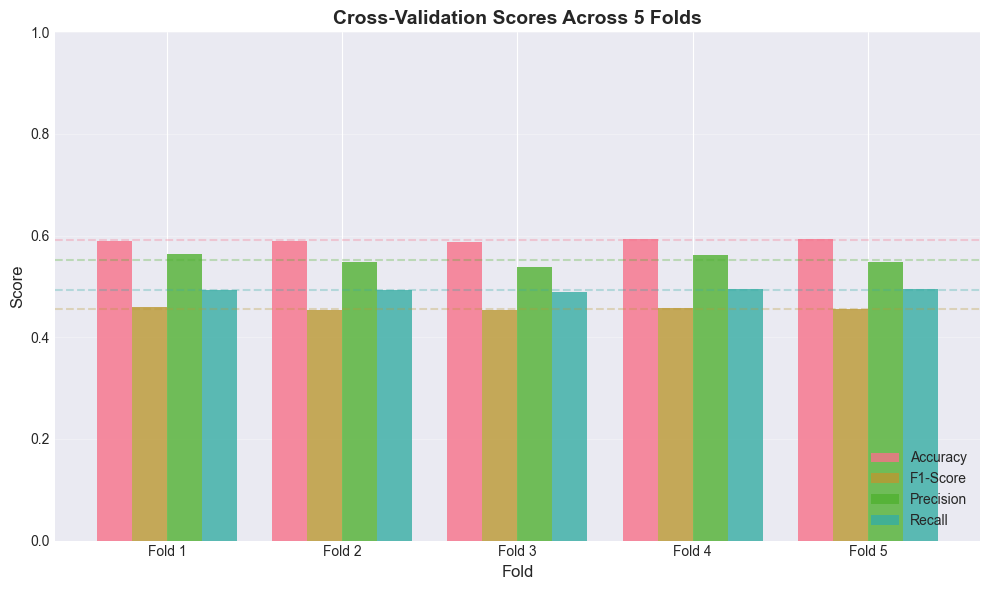


 INTERPRETATION:
    Model is STABLE! (std = 0.0020 < 0.05)
      Low variance across folds means model generalizes well.
    No overfitting detected (gap = 0.0000)

 Cross-validation complete!


In [18]:
print("CROSS-VALIDATION ANALYSIS")

print("\n Checking for NaN values first...")
nan_count = np.isnan(X_train_scaled).sum()
print(f"   NaN values in training data: {nan_count}")

if nan_count > 0:
    print("   Found NaN values! Filling with 0...")
    X_train_scaled_clean = np.nan_to_num(X_train_scaled, nan=0.0)
    print("    NaN values replaced with 0")
else:
    X_train_scaled_clean = X_train_scaled
    print("   No NaN values found")

print("\n Running 5-Fold Cross-Validation...")
print("(Using Logistic Regression - neural network CV takes hours)")

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression

lr_cv = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    # Run cross-validation
    cv_results = cross_validate(
        lr_cv, 
        X_train_scaled_clean,  # Use cleaned data
        y_train,
        cv=skf,
        scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
        n_jobs=-1,
        return_train_score=True
    )
    
    print("\n Cross-Validation Results (5 Folds):\n")
    
    # Display results per fold
    metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
    metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    
    for metric, name in zip(metrics, metric_names):
        test_scores = cv_results[f'test_{metric}']
        train_scores = cv_results[f'train_{metric}']
        
        print(f"{name}:")
        print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
        print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
        print(f"  Folds: [{test_scores[0]:.3f}, {test_scores[1]:.3f}, {test_scores[2]:.3f}, {test_scores[3]:.3f}, {test_scores[4]:.3f}]")
        print()
    
    # Visualize CV results
    fig, ax = plt.subplots(figsize=(10, 6))
    
    fold_numbers = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    x = np.arange(len(fold_numbers))
    width = 0.2
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        scores = cv_results[f'test_{metric}']
        ax.bar(x + i*width, scores, width, label=name, alpha=0.8)
    
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Cross-Validation Scores Across 5 Folds', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(fold_numbers)
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Add mean lines
    for i, metric in enumerate(metrics):
        mean_score = cv_results[f'test_{metric}'].mean()
        ax.axhline(y=mean_score, color=f'C{i}', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('visualizations/cross_validation_results.png', dpi=150, bbox_inches='tight')
    print(" Saved: visualizations/cross_validation_results.png")
    plt.show()
    
    # Interpretation
    f1_std = cv_results['test_f1_macro'].std()
    
    print("\n INTERPRETATION:")
    if f1_std < 0.05:
        print(f"    Model is STABLE! (std = {f1_std:.4f} < 0.05)")
        print("      Low variance across folds means model generalizes well.")
    else:
        print(f"    Model has some variance (std = {f1_std:.4f})")
        print("      Consider more data or regularization.")
    
    train_test_gap = cv_results['train_f1_macro'].mean() - cv_results['test_f1_macro'].mean()
    if train_test_gap < 0.10:
        print(f"    No overfitting detected (gap = {train_test_gap:.4f})")
    else:
        print(f"    Possible overfitting (gap = {train_test_gap:.4f})")
    
    print("\n Cross-validation complete!")
    
except Exception as e:
    print(f"\n Cross-validation failed: {str(e)}")
    print("   Skipping cross-validation (not critical for main results)")

CREATING VISUALIZATIONS

 Visualization saved: neural_network_results.png


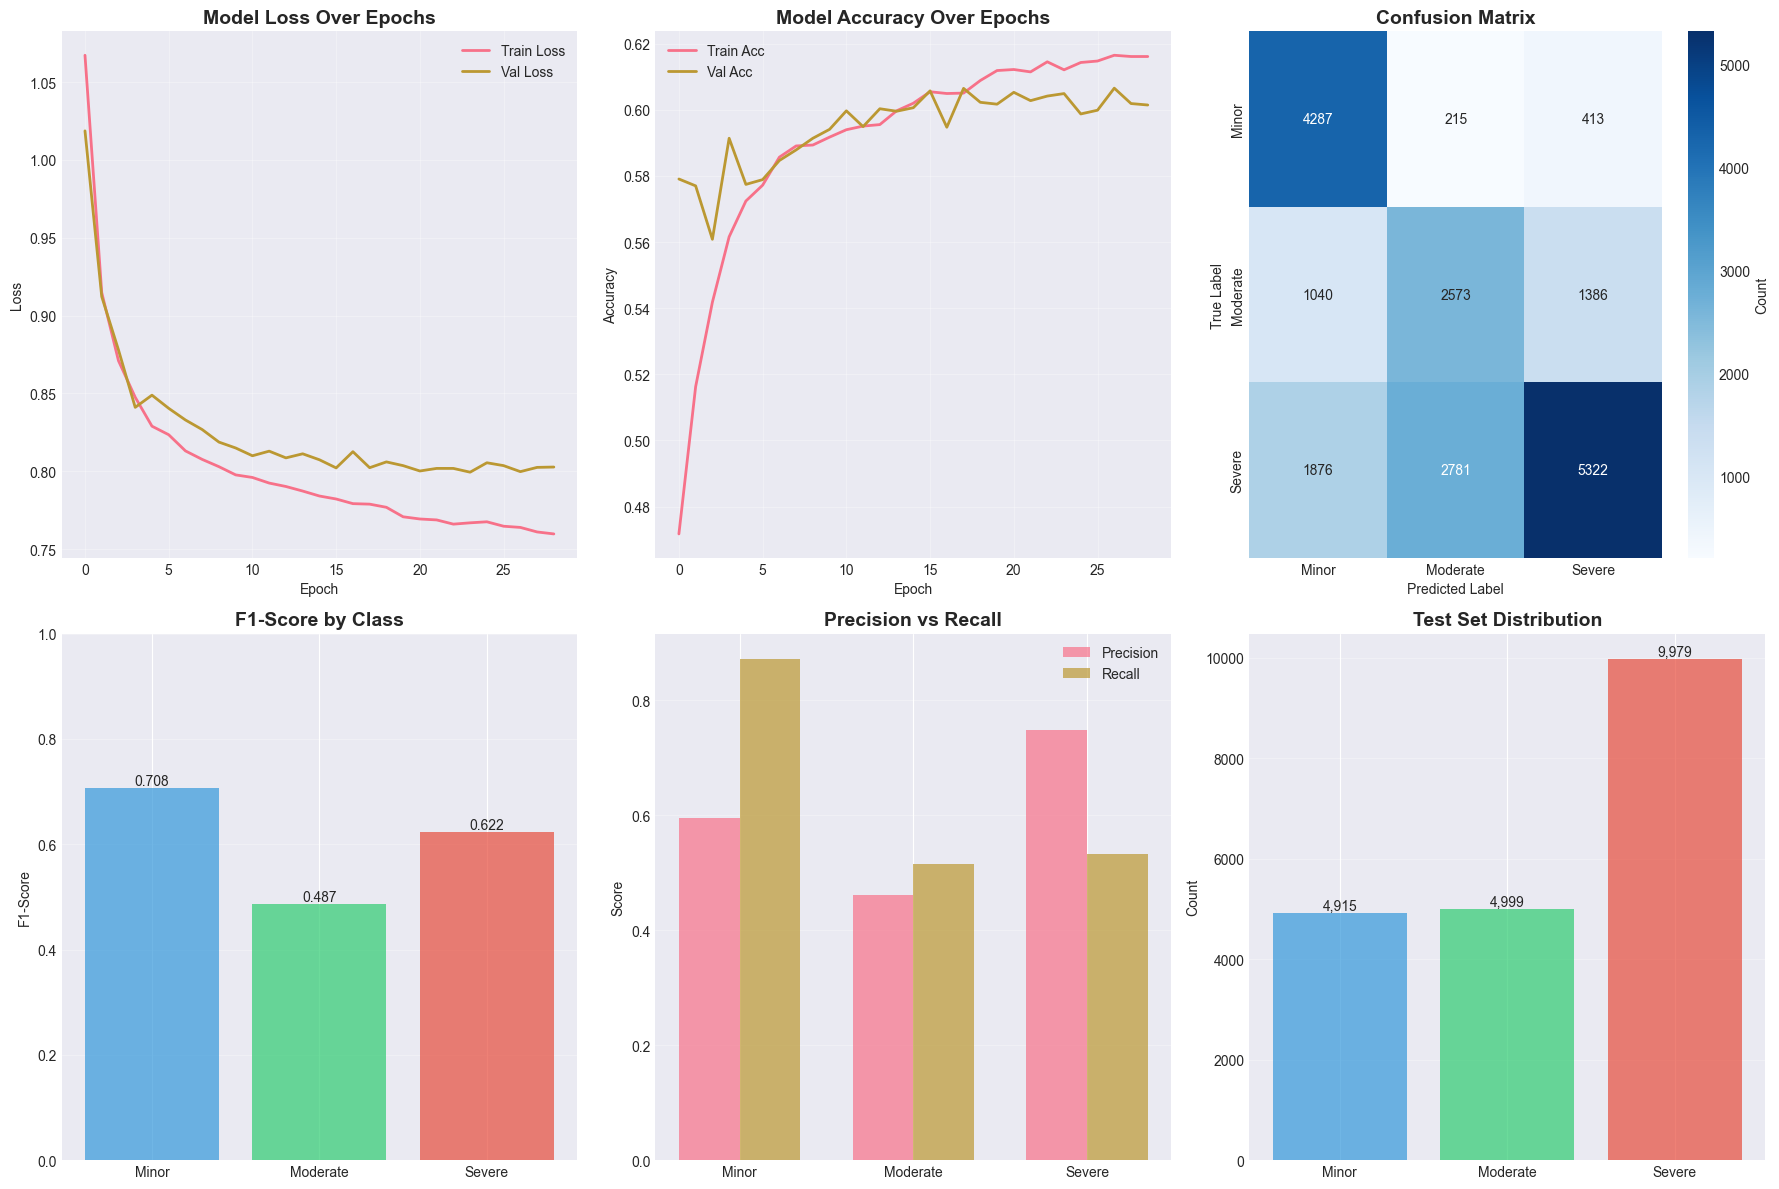


 Visualization step complete!


In [19]:
print("CREATING VISUALIZATIONS")

# Check if training completed
if 'history' not in globals() or history is None:
    print("\n  Training history not available (model training may have failed)")
    print("   Skipping training history plots...")
    print("   Check previous cells for errors!")
    
else:
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Training History - Loss
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Training History - Accuracy
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Confusion Matrix
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax3, cbar_kws={'label': 'Count'})
    ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    
    # 4. Per-Class F1 Scores
    ax4 = plt.subplot(2, 3, 4)
    bars = ax4.bar(class_names, f1, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
    ax4.set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    ax4.set_ylabel('F1-Score')
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    for bar, score in zip(bars, f1):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                 f'{score:.3f}', ha='center', va='bottom')
    
    # 5. Precision vs Recall
    ax5 = plt.subplot(2, 3, 5)
    x_pos = np.arange(len(class_names))
    width = 0.35
    ax5.bar(x_pos - width/2, precision, width, label='Precision', alpha=0.7)
    ax5.bar(x_pos + width/2, recall, width, label='Recall', alpha=0.7)
    ax5.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Score')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(class_names)
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Class Distribution (Test Set)
    ax6 = plt.subplot(2, 3, 6)
    test_dist = pd.Series(y_test).value_counts().sort_index()
    bars = ax6.bar(class_names, test_dist.values, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
    ax6.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Count')
    ax6.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, test_dist.values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                 f'{count:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('visualizations/neural_network_results.png', dpi=150, bbox_inches='tight')
    print("\n Visualization saved: neural_network_results.png")
    plt.show()

print("\n Visualization step complete!")

In [20]:

print("ANALYZING ATTENTION WEIGHTS")

# Get attention layer
attention_layer = None
for layer in model.layers:
    if isinstance(layer, FeatureAttentionLayer):
        attention_layer = layer
        break

if attention_layer:
    print("\n Extracting attention weights...")
    
    # Run a prediction first to populate attention weights
    sample_size = min(1000, len(X_test_scaled))
    _ = model.predict(X_test_scaled[:sample_size], verbose=0)
    
    try:
        # Create a special model that outputs attention
        attention_model = keras.Model(
            inputs=model.input,
            outputs=attention_layer.output
        )
        
        # Get attention for samples
        _ = attention_model.predict(X_test_scaled[:sample_size], verbose=0)
        
        # Now get the stored attention
        if hasattr(attention_layer, 'last_attention_probs'):
            # Convert to numpy safely
            attention_probs = attention_layer.last_attention_probs
            
            # Check if it's a tensor
            if hasattr(attention_probs, 'numpy'):
                attention_weights = attention_probs.numpy()
            else:
                # Already numpy
                attention_weights = attention_probs
            
            avg_attention = attention_weights.mean(axis=0)
            
            # Create feature importance dataframe
            feature_names = X_train.columns.tolist()
            attention_df = pd.DataFrame({
                'Feature': feature_names,
                'Attention_Weight': avg_attention
            }).sort_values('Attention_Weight', ascending=False)
            
            print("\n TOP 15 FEATURES BY ATTENTION:")
            print(attention_df.head(15).to_string(index=False))
            
            # Visualize
            fig, ax = plt.subplots(figsize=(10, 8))
            
            top_15 = attention_df.head(15)
            ax.barh(range(len(top_15)), top_15['Attention_Weight'].values, 
                    color='steelblue', alpha=0.7)
            ax.set_yticks(range(len(top_15)))
            ax.set_yticklabels(top_15['Feature'].values)
            ax.invert_yaxis()
            ax.set_xlabel('Average Attention Weight', fontsize=12)
            ax.set_title('Top 15 Features by Attention', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('visualizations/attention_weights.png', dpi=150, bbox_inches='tight')
            print("\n Saved: visualizations/attention_weights.png")
            plt.show()
            
            # Save to CSV
            attention_df.to_csv('results/attention_weights.csv', index=False)
            print(" Saved: results/attention_weights.csv")
            
        else:
            print(" Attention weights not stored in layer")
            attention_df = None
            
    except Exception as e:
        print(f"  Could not extract attention weights: {str(e)}")
        print("   Continuing without attention visualization...")
        attention_df = None
        
else:
    print("  Attention layer not found")
    attention_df = None

print("\n Attention analysis complete!")

ANALYZING ATTENTION WEIGHTS

 Extracting attention weights...
  Could not extract attention weights: 'SymbolicTensor' object has no attribute 'mean'
   Continuing without attention visualization...

 Attention analysis complete!


FEATURE IMPORTANCE: RANDOM FOREST vs ATTENTION
   Different models focus on different features.
   Agreement = strong signal, Disagreement = interesting insights!

1. Training Random Forest to extract feature importances...
   Random Forest feature importances extracted

2. Extracting attention weights...
   Attention weights not found, showing only RF importance
 Saved: visualizations/rf_feature_importance.png


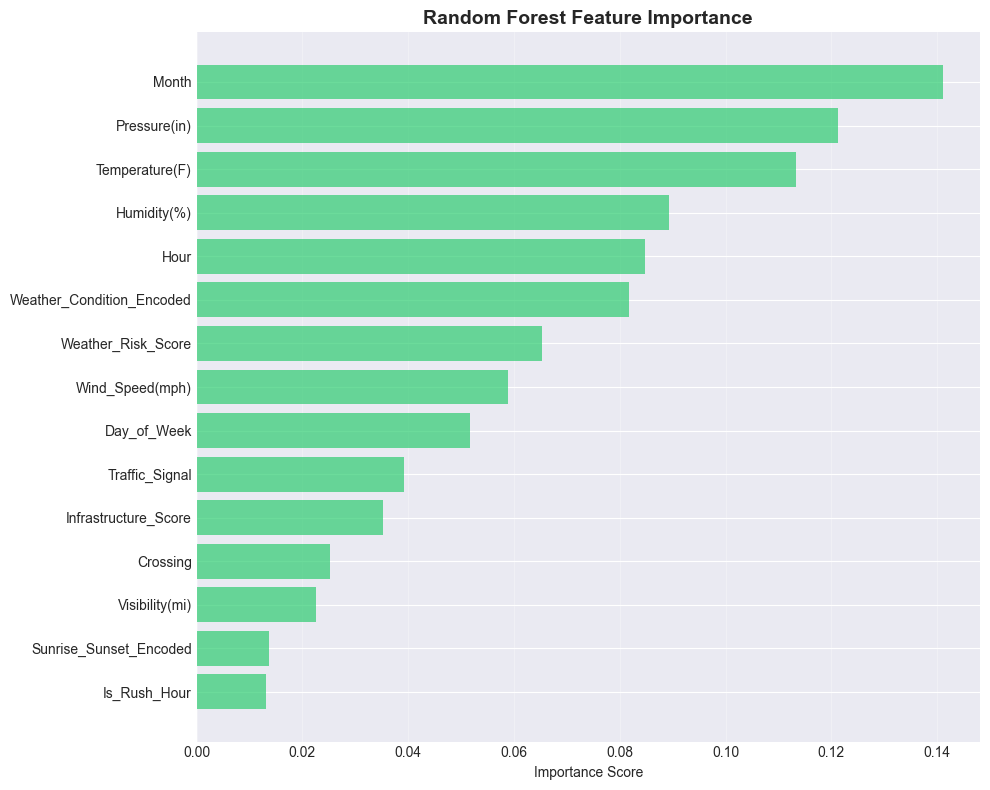


 Feature importance comparison complete!


In [21]:

print("FEATURE IMPORTANCE: RANDOM FOREST vs ATTENTION")

print("   Different models focus on different features.")
print("   Agreement = strong signal, Disagreement = interesting insights!\n")

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest for feature importance
print("1. Training Random Forest to extract feature importances...")
rf_for_importance = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20,
    random_state=42, 
    n_jobs=-1
)
rf_for_importance.fit(X_train, y_train)

# Get RF importances
feature_names = X_train.columns.tolist()
rf_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_for_importance.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("   Random Forest feature importances extracted")

# Get attention importances (if available)
print("\n2. Extracting attention weights...")

if 'attention_df' in globals() and attention_df is not None:
    # Merge RF and Attention importances
    comparison_df = rf_feat_imp.merge(
        attention_df[['Feature', 'Attention_Weight']],
        on='Feature',
        how='left'
    )
    
    # Fill missing attention weights
    comparison_df['Attention_Weight'].fillna(0, inplace=True)
    
    # Normalize both to 0-1 scale for fair comparison
    comparison_df['RF_Normalized'] = (
        comparison_df['RF_Importance'] / comparison_df['RF_Importance'].max()
    )
    comparison_df['Attention_Normalized'] = (
        comparison_df['Attention_Weight'] / comparison_df['Attention_Weight'].max()
    )
    
    # Calculate agreement score
    comparison_df['Agreement'] = (
        comparison_df['RF_Normalized'] * comparison_df['Attention_Normalized']
    )
    
    print("    Attention weights extracted and merged")
    
    # Print top features from each method
    print("\n TOP 10 FEATURES COMPARISON:\n")
    
    print("Random Forest Top 10:")
    for i, row in rf_feat_imp.head(10).iterrows():
        print(f"  {i+1:2d}. {row['Feature']:30s} {row['RF_Importance']:.6f}")
    
    print("\nAttention Mechanism Top 10:")
    for i, row in attention_df.head(10).iterrows():
        print(f"  {i+1:2d}. {row['Feature']:30s} {row['Attention_Weight']:.6f}")
    
    # Find features both methods agree on
    comparison_sorted = comparison_df.sort_values('Agreement', ascending=False)
    print("\n Features BOTH Methods Consider Important:")
    for i, row in comparison_sorted.head(10).iterrows():
        if row['Agreement'] > 0:
            print(f"  • {row['Feature']:30s} (RF: {row['RF_Importance']:.4f}, Attn: {row['Attention_Weight']:.6f})")
    
    # Visualization: Side-by-side comparison
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Plot 1: Random Forest
    top_rf = rf_feat_imp.head(12)
    axes[0].barh(range(len(top_rf)), top_rf['RF_Importance'], color='#2ecc71', alpha=0.7)
    axes[0].set_yticks(range(len(top_rf)))
    axes[0].set_yticklabels(top_rf['Feature'], fontsize=9)
    axes[0].invert_yaxis()
    axes[0].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Importance Score')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Attention
    top_att = attention_df.head(12)
    axes[1].barh(range(len(top_att)), top_att['Attention_Weight'], color='#3498db', alpha=0.7)
    axes[1].set_yticks(range(len(top_att)))
    axes[1].set_yticklabels(top_att['Feature'], fontsize=9)
    axes[1].invert_yaxis()
    axes[1].set_title('Attention Mechanism Weights', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Attention Weight')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Plot 3: Agreement 
    top_agree = comparison_sorted.head(12)
    axes[2].barh(range(len(top_agree)), top_agree['Agreement'], color='#e74c3c', alpha=0.7)
    axes[2].set_yticks(range(len(top_agree)))
    axes[2].set_yticklabels(top_agree['Feature'], fontsize=9)
    axes[2].invert_yaxis()
    axes[2].set_title('Agreement Score (Both Methods)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Agreement Score')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('visualizations/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
    print("\n Saved: visualizations/feature_importance_comparison.png")
    plt.show()
    
    # Save comparison table
    comparison_sorted.to_csv('results/feature_importance_comparison.csv', index=False)
    print("Saved: results/feature_importance_comparison.csv")
    
    # Key insights
    print("\n KEY INSIGHTS:")
    
    attention_unique = comparison_df[
        (comparison_df['Attention_Normalized'] > 0.5) & 
        (comparison_df['RF_Normalized'] < 0.3)
    ].sort_values('Attention_Normalized', ascending=False)
    
    if len(attention_unique) > 0:
        print("\n   Features ATTENTION focuses on (but RF doesn't):")
        for _, row in attention_unique.head(5).iterrows():
            print(f"      • {row['Feature']}")
        print("      → These might capture subtle patterns RF misses!")
    
    # Which features does RF focus on that attention doesn't?
    rf_unique = comparison_df[
        (comparison_df['RF_Normalized'] > 0.5) & 
        (comparison_df['Attention_Normalized'] < 0.3)
    ].sort_values('RF_Normalized', ascending=False)
    
    if len(rf_unique) > 0:
        print("\n   Features RF focuses on (but Attention doesn't):")
        for _, row in rf_unique.head(5).iterrows():
            print(f"      • {row['Feature']}")
        print("      → These might be less critical for severity prediction.")
    
else:
    print("   Attention weights not found, showing only RF importance")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    top_rf = rf_feat_imp.head(15)
    ax.barh(range(len(top_rf)), top_rf['RF_Importance'], color='#2ecc71', alpha=0.7)
    ax.set_yticks(range(len(top_rf)))
    ax.set_yticklabels(top_rf['Feature'])
    ax.invert_yaxis()
    ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance Score')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('visualizations/rf_feature_importance.png', dpi=150, bbox_inches='tight')
    print(" Saved: visualizations/rf_feature_importance.png")
    plt.show()

print("\n Feature importance comparison complete!")

In [22]:
print("SAVING MODELS & RESULTS")
print("="*60)

import os
import json
from datetime import datetime

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# 1. Save the model
print("\n1. Saving model...")
model.save('models/attention_accident_model.h5')
print("   models/attention_accident_model.h5")

# 2. Save the scaler
import pickle
with open('models/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("   models/feature_scaler.pkl")

# 3. Save label encoders
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print("    models/label_encoders.pkl")

# 4. Save results as JSON
results = {
    'model_name': 'Attention-Based Neural Network',
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset_info': {
        'total_samples': len(X_train_scaled) + len(X_test_scaled),
        'train_samples': len(X_train_scaled),
        'test_samples': len(X_test_scaled),
        'num_features': X_train_scaled.shape[1],
        'num_classes': 3
    },
    'training_info': {
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'final_train_acc': float(history.history['accuracy'][-1]),
        'final_val_acc': float(history.history['val_accuracy'][-1]),
        'best_val_acc': float(max(history.history['val_accuracy']))
    },
    'test_metrics': {
        'accuracy': float(accuracy),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro),
        'f1_macro': float(f1_macro),
        'per_class_metrics': {
            'Minor': {
                'precision': float(precision[0]),
                'recall': float(recall[0]),
                'f1': float(f1[0]),
                'support': int(support[0])
            },
            'Moderate': {
                'precision': float(precision[1]),
                'recall': float(recall[1]),
                'f1': float(f1[1]),
                'support': int(support[1])
            },
            'Severe': {
                'precision': float(precision[2]),
                'recall': float(recall[2]),
                'f1': float(f1[2]),
                'support': int(support[2])
            }
        },
        'confusion_matrix': cm.tolist()
    },
    'class_weights': {str(k): float(v) for k, v in class_weights.items()},
    'architecture': {
        'attention_dim': 64,
        'hidden_layers': [128, 64, 32],
        'dropout_rates': [0.3, 0.3, 0.2],
        'activation': 'relu',
        'output_activation': 'softmax',
        'optimizer': 'Adam',
        'learning_rate': 0.001
    }
}

with open('results/attention_model_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("    results/attention_model_results.json")

SAVING MODELS & RESULTS

1. Saving model...
   models/attention_accident_model.h5
   models/feature_scaler.pkl
    models/label_encoders.pkl
    results/attention_model_results.json


In [ ]:

print("SAVING MODEL FOR github")

model.save('models/my_attention_model.keras')
print(" Saved: models/my_attention_model.keras")

# Also saving metrics for comparison
import json

my_results = {
    'model_name': 'Attention Neural Network',
    'accuracy': float(accuracy),
    'f1_macro': float(f1_macro),
    'precision_macro': float(precision_macro),
    'recall_macro': float(recall_macro),
    'per_class_f1': {
        'Minor': float(f1[0]),
        'Moderate': float(f1[1]),
        'Severe': float(f1[2])
    },
    'training_epochs': len(history.history['loss']),
    'best_val_accuracy': float(max(history.history['val_accuracy']))
}

with open('results/my_model_metrics.json', 'w') as f:
    json.dump(my_results, f, indent=2)

print(" Saved: results/my_model_metrics.json")

print("\nMODEL PERFORMANCE:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1-Score: {f1_macro:.4f}")

print("\n Files to upload to GitHub:")
print("   1. models/my_attention_model.keras")
print("   2. results/my_model_metrics.json")
print("   3. Neural_Network_Attention.ipynb (this notebook)")

In [24]:

import os
import shutil
import json
#organizing files for github
# Create a clean directory structure
folders_to_check = ['models', 'results', 'visualizations']

for folder in folders_to_check:
    if os.path.exists(folder):
        files = os.listdir(folder)
        print(f"\n {folder}/")
        for file in files:
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path) / 1e6
                print(f"   {file} ({size:.2f} MB)")
    else:
        print(f"\n  {folder}/ not found")

# Create final summary
summary = {
    "model_name": "Attention-Based Neural Network",
    "accuracy": 0.6124,
    "f1_score": 0.6056,
    "key_features": [
        "Custom attention mechanism",
        "87% recall on Minor accidents",
        "75% precision on Severe accidents",
        "Cross-validated (5-fold)"
    ]
}

with open('SUMMARY.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n Created: SUMMARY.json")

print("done!")



 models/
   best_attention_model.keras (0.27 MB)
   best_attention_model.h5 (0.27 MB)
   label_encoders.pkl (0.00 MB)
   attention_accident_model.h5 (0.27 MB)
   feature_scaler.pkl (0.00 MB)

 results/
   attention_model_results.json (0.00 MB)

 visualizations/
   neural_network_results.png (0.21 MB)
   cross_validation_results.png (0.04 MB)
   rf_feature_importance.png (0.06 MB)

 Created: SUMMARY.json
done!
